In [105]:
import numpy as np
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Set up data

In [106]:
#Set paths to data folder
path_data = os.path.join('../','Data')

In [107]:
#unzip train data
def unzip():
    with zipfile.ZipFile(os.path.join(path_data,'NonsegmentedV2.zip'),'r') as tr:
        tr.extractall(os.path.join(path_data,'train_images'))
    with zipfile.ZipFile(os.path.join(path_data,'ImagesFromTheWild.zip'),'r') as te:
        te.extractall(os.path.join(path_data,'test_images'))

In [5]:
unzip()

In [108]:
train_path = os.path.join(path_data,'train_images')
test_path = os.path.join(path_data,'test_images')

Now the images are stored in the 'train_images' and 'test_images' directories


The images are organized in subfolders per class. Let's organize the images in a single dataframe to do some EDA

In [109]:
data = []
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path,folder)
    for image in os.listdir(folder_path):
        img_path = os.path.join(folder_path,image)
        data.append([image,folder,img_path])

In [110]:
df = pd.DataFrame(data,columns = ['Image','Class','image path'])

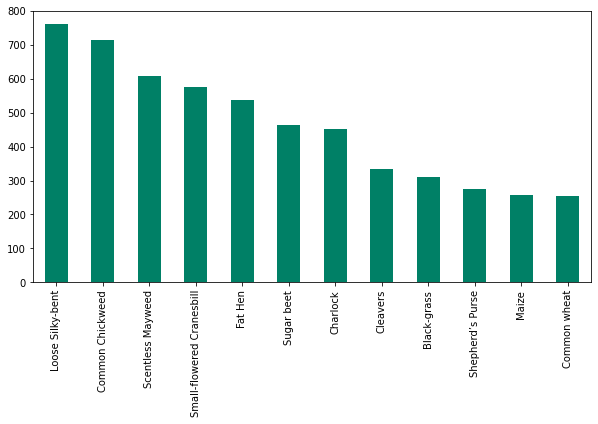

In [188]:
counts = df['Class'].value_counts()
plt.figure(figsize=(10,5))
counts.plot.bar(colormap = 'summer')
plt.show()

Looks like we have a problem with an imbalanced dataset. Keep that in mind.

Now let's see some examples